In [32]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import torchvision.models as models
import torchvision.transforms as transforms
import torch.nn as nn
from torch.optim import Optimizer, Adam, SGD
from torchvision import transforms, datasets
from torch.utils.data import Subset
from torch.utils.data import TensorDataset, DataLoader
from torch.nn.functional import softmax
from torch import optim
from sklearn.model_selection import train_test_split
from tqdm import tqdm
from PIL import ImageFile

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

(1.0, 1000.0)

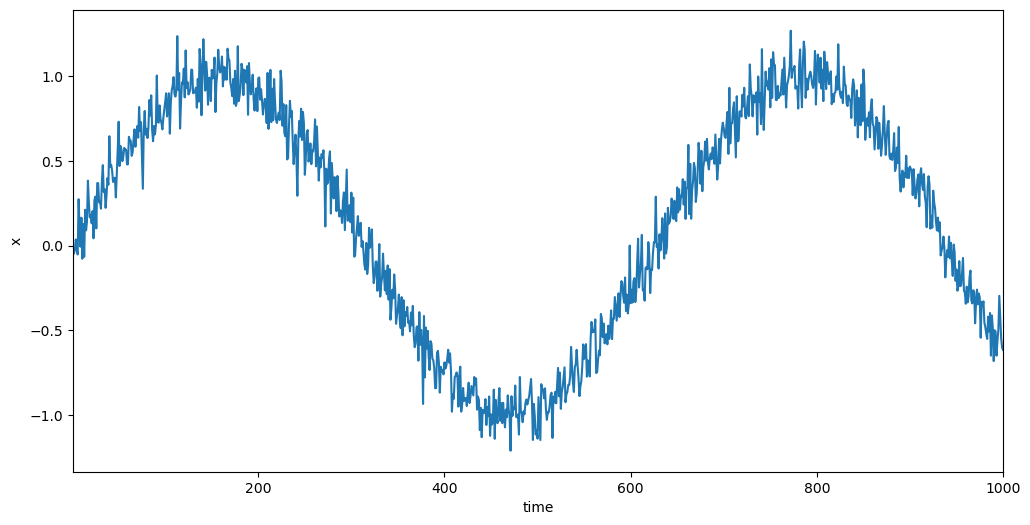

In [33]:
T = 1000  # Generate a total of 1000 points
time = np.arange(1, T + 1, dtype=np.float32)
x = np.sin(0.01 * time) + np.random.normal(0, 0.1, (T,))

plt.figure(figsize=(12, 6))
plt.plot(time, x)
plt.ylabel('x')
plt.xlabel('time')
plt.xlim([1, 1000])

In [34]:
# define a train function, model-agnostic, which will be used for further training
def train(net, train_loader, device, num_epochs, learning_rate):
    
    optimizer = optim.Adam(net.parameters(), lr=learning_rate)
    loss_function = torch.nn.L1Loss()
    loss_history = []

    with tqdm(total=len(train_loader)*num_epochs, position=0, leave=True) as pbar:

        for epoch in range(num_epochs):
            running_loss = 0.0
            
            for batch_num, (inputs, labels) in enumerate(train_loader):
                inputs = inputs.to(device)
                labels = labels.to(device)
                
                optimizer.zero_grad()
                
                result = net(inputs)
                loss = loss_function(result, labels)
                
                # Backpropagation                
                loss.backward()

                # Update
                optimizer.step()

                # Print progress
                running_loss += loss.item()
                
            pbar.set_description("Epoch: %d, Loss: %.2f" % (epoch, running_loss))
            pbar.update()
                
            loss_history.append(running_loss)

        pbar.close()

    return loss_history

def print_loss(history) -> None:
    plt.figure(figsize=(7, 4))
    plt.plot(history)
    plt.title('Model Loss')
    plt.ylabel('Loss')
    plt.xlabel('Iteration')

In [35]:
class customNLP(nn.Module):
    def __init__(self, *args, **kwargs) -> None:
        super().__init__(*args, **kwargs)
        self.layer1 = nn.Sequential(
            nn.Linear(16, 8),
            nn.ReLU()
        )
        self.layer2 = nn.Sequential(
            nn.Linear(8, 4),
            nn.ReLU()
        )
        self.layer3 = nn.Sequential(
            nn.Linear(4, 1)
        )
        
    def forward(self, x) -> float:
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        return x

In [36]:
tau = 16
features = np.zeros((T - tau, tau))
for i in range(tau):
    features[:, i] = x[i: T - tau + i]
labels = x[tau:].reshape((-1, 1))
print(labels.shape)

batch_size, n_train = 16, 600

x_train = features[:n_train]
y_train = labels[:n_train]

tensor_x = torch.Tensor(x_train) # transform to torch tensor
tensor_y = torch.Tensor(y_train)

dataset = TensorDataset(tensor_x,tensor_y) # create your datset
train_loader = DataLoader(dataset) # create your dataloader

(984, 1)


  0%|          | 0/60000 [00:00<?, ?it/s]

Epoch: 99, Loss: 49.26:   0%|          | 100/60000 [00:51<8:33:36,  1.94it/s]


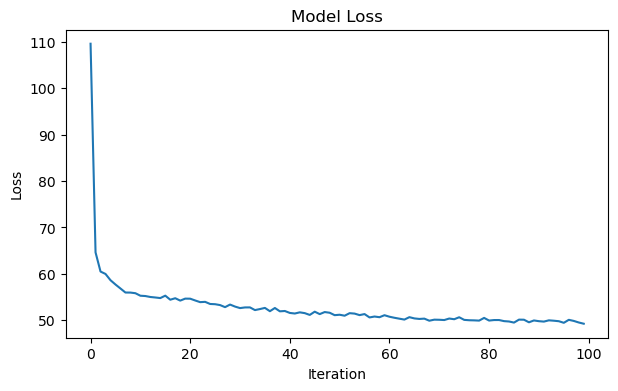

In [37]:
NUM_EPOCHS = 100
LR = 0.001

net = customNLP().to(device)

print_loss(train(net, train_loader, device, NUM_EPOCHS, LR))

In [38]:
def set_axes(axes, xlabel, ylabel, xlim, ylim, xscale, yscale, legend):
    """Set the axes for matplotlib.

    Defined in :numref:`sec_calculus`"""
    axes.set_xlabel(xlabel) 
    axes.set_ylabel(ylabel)
    axes.set_xscale(xscale)
    axes.set_yscale(yscale)
    axes.set_xlim(xlim)
    axes.set_ylim(ylim)
    if legend:
        axes.legend(legend)
    axes.grid()


def plot(X, Y=None, xlabel=None, ylabel=None, legend=None, xlim=None,
         ylim=None, xscale='linear', yscale='linear',
         fmts=('-', 'm--', 'g-.', 'r:', 'k:'), figsize=(6, 3), axes=None):
    """Plot data points.

    Defined in :numref:`sec_calculus`"""
    if legend is None:
        legend = []

    plt.rcParams["figure.figsize"] = figsize
    axes = axes if axes else plt.gca()

    # Return True if `X` (tensor or list) has 1 axis
    def has_one_axis(X):
        return (hasattr(X, "ndim") and X.ndim == 1 or isinstance(X, list)
                and not hasattr(X[0], "__len__"))

    if has_one_axis(X):
        X = [X]
    if Y is None:
        X, Y = [[]] * len(X), X
    elif has_one_axis(Y):
        Y = [Y]
    if len(X) != len(Y):
        X = X * len(Y)
    axes.cla()
    for x, y, fmt in zip(X, Y, fmts):
        if len(x):
            axes.plot(x, y, fmt)
        else:
            axes.plot(y, fmt)
    set_axes(axes, xlabel, ylabel, xlim, ylim, xscale, yscale, legend)

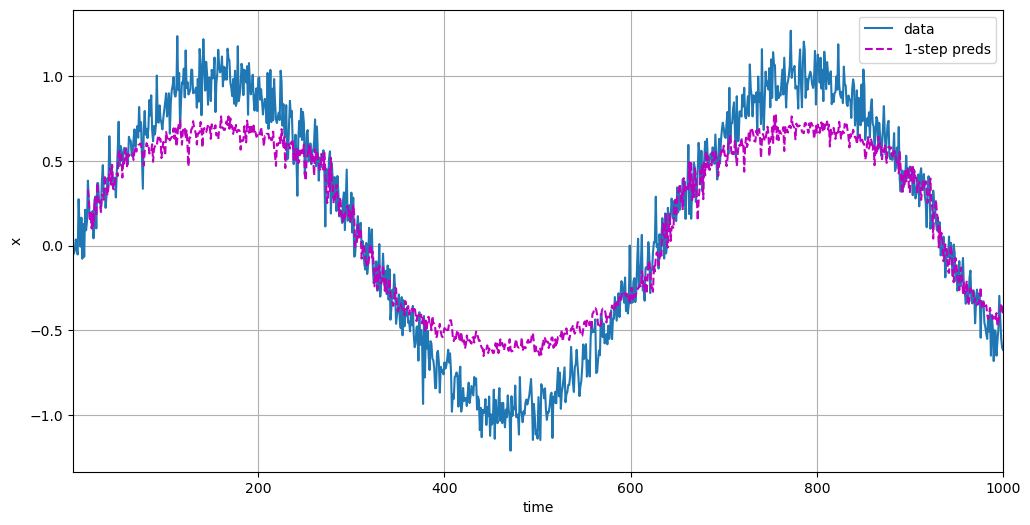

In [39]:
tensor_features = torch.Tensor(features).to(device)

onestep_preds = net(tensor_features)

plot([time, time[tau:]], [x, onestep_preds.detach().cpu().numpy()], 'time',
      'x', legend=['data', '1-step preds'], xlim=[1, 1000], figsize=(12, 6))

### Попытаемся обучить RNN

In [62]:
class customRNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, num_layers=2, dropout=0.2):
        super(customRNN, self).__init__()
        self.rnn = nn.RNN(input_size, hidden_size, num_layers=num_layers, 
                             batch_first=True, dropout=dropout, bidirectional=True)
        self.fc = nn.Linear(hidden_size * 2, output_size)

    def forward(self, x):
        x = x.unsqueeze(2)
        rnn_out, _ = self.rnn(x)
        out = self.fc(rnn_out[:, -1, :])
        return out


In [66]:
input_size = 1
hidden_size = 64 
output_size = 1 
dropout = 0.2 
num_layers = 4
NUM_EPOCHS = 100
LR = 0.001

  0%|          | 0/60000 [00:00<?, ?it/s]

Epoch: 99, Loss: 65.76:   0%|          | 100/60000 [02:02<20:25:53,  1.23s/it]


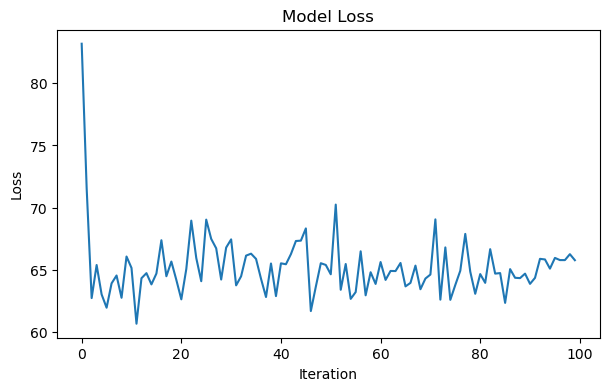

In [67]:
net_rnn = customRNN(input_size, hidden_size, output_size, num_layers).to(device)

print_loss(train(net_rnn, train_loader, device, NUM_EPOCHS, LR))


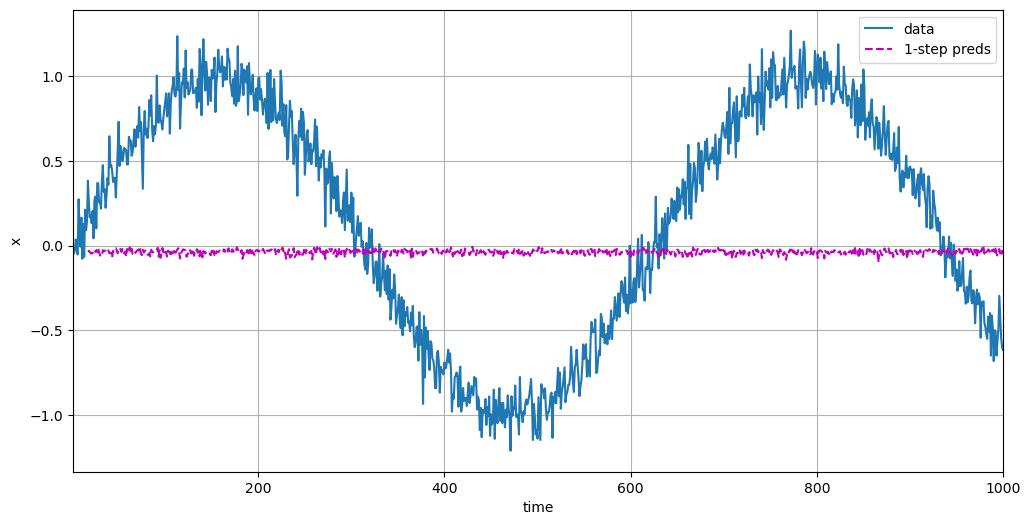

In [65]:

tensor_features = torch.Tensor(features).to(device)
onestep_preds_rnn = net_rnn(tensor_features)

plot([time, time[tau:]], [x, onestep_preds_rnn.detach().cpu().numpy()], 'time',
     'x', legend=['data', '1-step preds'], xlim=[1, 1000], figsize=(12, 6))


In [ ]:
class customLSTM(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, num_layers=2, dropout=0.2):
        super(customLSTM, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers=num_layers, 
                             batch_first=True, dropout=dropout, bidirectional=True)
        self.fc = nn.Linear(hidden_size * 2, output_size)

    def forward(self, x):
        x = x.unsqueeze(2)
        lstm_out, _ = self.lstm(x)
        out = self.fc(lstm_out[:, -1, :])
        return out


In [59]:
input_size = 1
hidden_size = 64 
output_size = 1 
num_layers = 2
dropout = 0.2 
NUM_EPOCHS = 100
LR = 0.001

Epoch: 99, Loss: 60.97:   0%|          | 100/60000 [01:56<19:25:37,  1.17s/it]


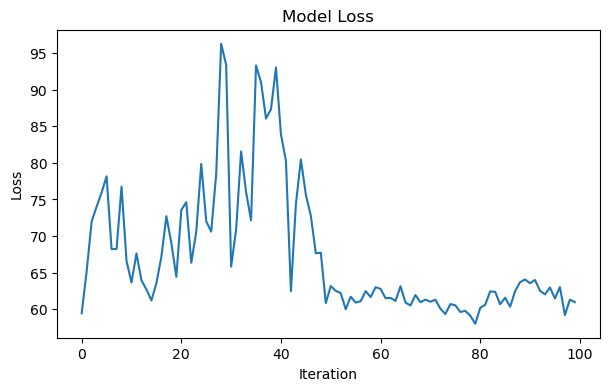

In [60]:

net_lstm = customLSTM(input_size, hidden_size, output_size, num_layers, dropout).to(device)

print_loss(train(net_lstm, train_loader, device, NUM_EPOCHS, LR))


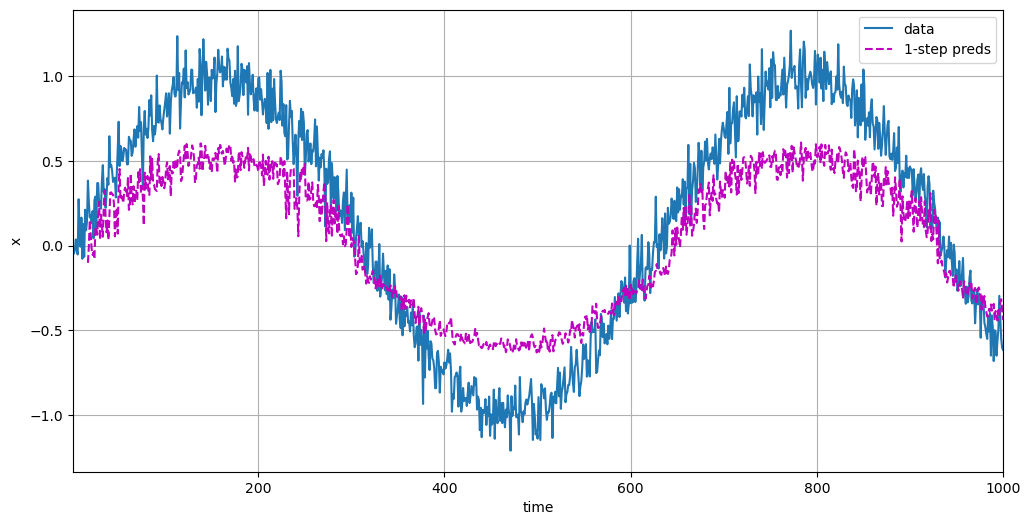

In [61]:
tensor_features = torch.Tensor(features).to(device)
onestep_preds_lstm = net_lstm(tensor_features)

plot([time, time[tau:]], [x, onestep_preds_lstm.detach().cpu().numpy()], 'time',
     'x', legend=['data', '1-step preds'], xlim=[1, 1000], figsize=(12, 6))

**Вывод:** блок LSTM повышает точность

In [81]:
class customNet(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, num_layers=2, dropout=0.2):
        super(customNet, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers=num_layers, 
                             batch_first=True, dropout=dropout, bidirectional=True)
        
        self.layer1 = nn.Sequential(
            nn.Linear(hidden_size * 2, 64),
            nn.ReLU()
        )
        self.layer2 = nn.Sequential(
            nn.Linear(64, 64),
            nn.ReLU()
        )
        self.layer3 = nn.Sequential(
            nn.Linear(64, output_size)
        )

    def forward(self, x):
        x = x.unsqueeze(2)
        lstm_out, _ = self.lstm(x)
        x = self.layer1(lstm_out[:, -1, :])
        x = self.layer2(x)
        x = self.layer3(x)
        return x


In [89]:
input_size = 1
hidden_size = 64 
output_size = 1 
num_layers = 2
dropout = 0.25 
NUM_EPOCHS = 100
LR = 0.001

Epoch: 99, Loss: 64.79:   0%|          | 100/60000 [03:10<31:41:01,  1.90s/it]


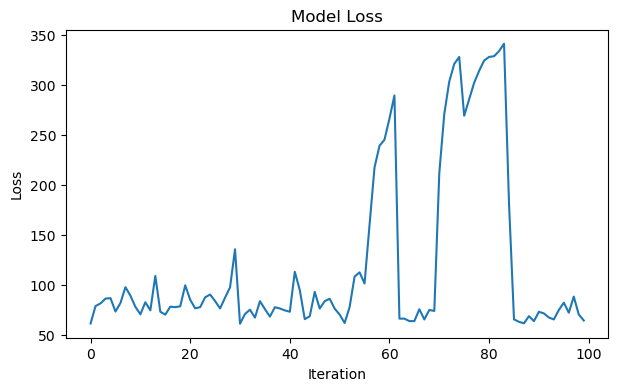

In [90]:

net = customNet(input_size, hidden_size, output_size, num_layers, dropout).to(device)

print_loss(train(net, train_loader, device, NUM_EPOCHS, LR))


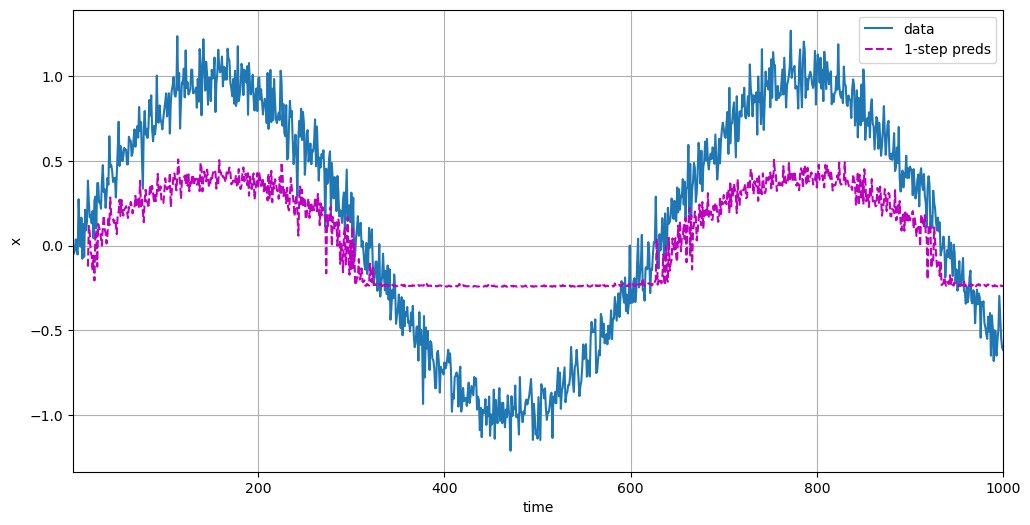

In [ ]:
tensor_features = torch.Tensor(features).to(device)
onestep_preds = net(tensor_features)

plot([time, time[tau:]], [x, onestep_preds.detach().cpu().numpy()], 'time',
     'x', legend=['data', '1-step preds'], xlim=[1, 1000], figsize=(12, 6))